In [1]:
# Load Libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [4]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()})
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt','Time','SS']]
df_SS = df[['freqQAmpI_filt','SS']]
df_A = df[['freqQAmpI_filt','freqQAmpI_filt']]
xdf = df[['freqQAmpI_filt']]
ydf = df[['SS']]

df_SS = df_SS[0:100000]
df_A = df_A[0:100000]
xdf = xdf[0:100000]
ydf = ydf[0:100000]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt
0        31453.223522
1        31438.277060
2        31421.341616
3        31409.798761
4        31398.815589
...               ...
99995    30869.698791
99996    30863.630877
99997    30859.759206
99998    30859.287324
99999    30844.600734

[100000 rows x 1 columns]
Target Data:
              SS
0      5.656166
1      5.657157
2      5.658317
3      5.659499
4      5.660404
...         ...
99995  5.777328
99996  5.778124
99997  5.778968
99998  5.779630
99999  5.780332

[100000 rows x 1 columns]


In [5]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (99700, 300, 1)
Target shape (SS), Y =  (99700,)
After reshaping, X =  (99700, 300)


In [6]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 69790
Validation samples: 9970
Testing samples: 19940


In [7]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

**Define Data-Driven Model**

In [8]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(300,),name='X_train')

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred])
  return model

In [9]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer= tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ X_train (InputLayer)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,657 (151.00 KB)

 Trainable params: 38,657 (151.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2180/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299 - mse: 0.0299
Epoch 1: val_loss improved from inf to 0.01353, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check.keras
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 2/100
2163/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mse: 0.0104
Epoch 2: val_loss improved from 0.01353 to 0.01152, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check.keras
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 3/100
2178/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - mse: 0.0086
Epoch 3: val_loss improved from 0.01152 to 0.01056, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check.keras
2181/2

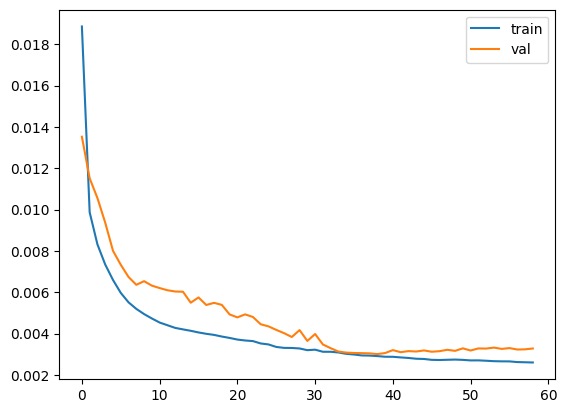

---Training time: 467.39593315 seconds ---


In [10]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [11]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

# Model Performance: Validation
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)

val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f" %(train_r2_SS))
print("R2 scores: Validation (SS) - %0.5f" %(val_r2_SS))

2181/2181 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R2 scores: Train (SS) - 0.89074
R2 scores: Validation (SS) - 0.88079
